In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
import reading_util as ru
import writing_util as wu
import plotting_util as pu
import string_constants as sc
import data_sample as ds
import parameter as pa
import analysis_model_performance as amp
import string_constants_vae_check as sc_check

In [3]:
def get_mjj_binned_sample( sample, mjj_peak, window_pct ):
    
    left_edge, right_edge = mjj_peak*(1.-window_pct/100.), mjj_peak*(1.+window_pct/100.)
    
    left_bin = sample[ sample['mJJ'] < left_edge ]
    center_bin = sample[ (sample['mJJ'] >= left_edge) & (sample['mJJ'] <= right_edge) ]
    right_bin = sample[ sample['mJJ'] > right_edge ]
    
    left_bin_ds = ds.DataSample(sample.title() + ' mJJ < ' + str(left_edge/1000), left_bin)
    center_bin_ds = ds.DataSample(sample.title()+' '+str(left_edge/1000)+' <= mJJ <= '+str(right_edge/1000), center_bin)
    right_bin_ds = ds.DataSample( sample.title()+' mJJ > '+str(right_edge/1000), right_bin )
    
    return [left_bin_ds, center_bin_ds, right_bin_ds ]

# runtime parameters

In [4]:
strategy = pa.loss_strategy_dict['s5'] # L1 & L2
model = 38 # training on old qcd

# read data

In [5]:
SM_sample = 'qcdSide_old'
BSM_samples_old = ['GtoTTbr_old','GtoTTna_old','GtoWW25na_old']
BSM_samples_new = ['GtoWW15na_new', 'GtoWW25na_new', 'GtoWW30na_new', 'GtoWW45na_new', 'GtoWW15br_new', 'GtoWW25br_new']
all_samples = [SM_sample] + BSM_samples_old + BSM_samples_new

In [6]:
# read in data
input_data = OrderedDict()
for name in all_samples:
    print(name)
    path = os.path.join( sc_check.result_dir_old_data, sc_check.model_dict[model], sc_check.sample_result_loc[name] )
    input_data[name] = ds.read_datasample_from_file( name, os.path.join( sc.result_dir, path ) )


qcdSide_old
GtoTTbr_old
GtoTTna_old
GtoWW25na_old
GtoWW15na_new
GtoWW25na_new
GtoWW30na_new
GtoWW45na_new
GtoWW15br_new
GtoWW25br_new


# plot loss distribution

## old signals

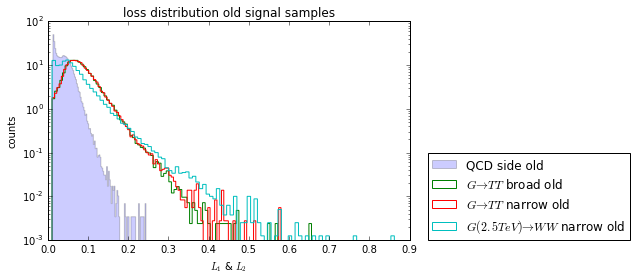

In [7]:
losses = [strategy(input_data[sample]) for sample in [SM_sample] + BSM_samples_old]
legend = [input_data[sample].title() for sample in [SM_sample] + BSM_samples_old]
_ = amp.plot_bg_vs_sig_distribution(losses, xlabel=r'$L_1$ & $L_2$', legend=legend, title=r'loss distribution old signal samples',ylogscale=True, normed=True, legend_loc=(1.05,0))

## new signals

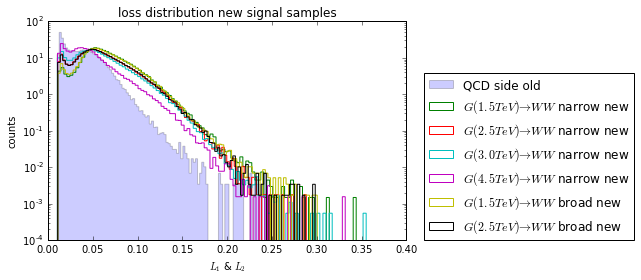

In [8]:
losses = [strategy(input_data[sample]) for sample in [SM_sample] + BSM_samples_new]
legend = [input_data[sample].title() for sample in [SM_sample] + BSM_samples_new]
_ = amp.plot_bg_vs_sig_distribution(losses, xlabel=r'$L_1$ & $L_2$', legend=legend, title=r'loss distribution new signal samples',ylogscale=True, normed=True, legend_loc=(1.05,0))

# plot standard ROC

## old signals

In [9]:
neg_class_loss = [ strategy( input_data[SM_sample] ) ]
pos_class_losses = [ strategy( input_data[BSM_sample] ) for BSM_sample in BSM_samples_old ]
legend = [ input_data[BSM_sample].title() for BSM_sample in BSM_samples_old]

In [10]:
class_labels, losses = amp.get_label_and_score_arrays( neg_class_loss*len(pos_class_losses), pos_class_losses ) # neg_class_loss array same for all pos_class_losses

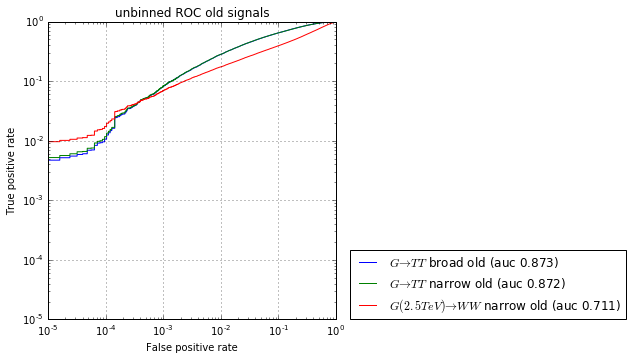

[0.8725630948134893, 0.8724600458692506, 0.711298851298224]

In [11]:
amp.plot_roc( class_labels, losses, legend, title='unbinned ROC old signals', legend_loc=(1.05,0) )

## new signals

In [12]:
neg_class_loss = [ strategy( input_data[SM_sample] ) ]
pos_class_losses = [ strategy( input_data[BSM_sample] ) for BSM_sample in BSM_samples_new ]
legend = [ input_data[BSM_sample].title() for BSM_sample in BSM_samples_new]

In [13]:
class_labels, losses = amp.get_label_and_score_arrays( neg_class_loss*len(pos_class_losses), pos_class_losses ) # neg_class_loss array same for all pos_class_losses

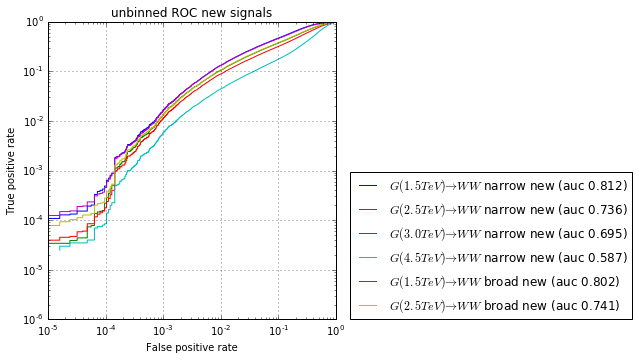

[0.8115828046748188,
 0.7362573078614356,
 0.6954736419462108,
 0.5874858553709758,
 0.8021808888095097,
 0.7409090074802247]

In [14]:
amp.plot_roc( class_labels, losses, legend, title='unbinned ROC new signals', legend_loc=(1.05,0) )

# plot binned ROC

## old signals

mean = 1707.72, min = 1100.04, max = 1999.98
mean = 2518.26, min = 2000.02, max = 2999.97
mean = 3266.55, min = 3000.10, max = 5915.88


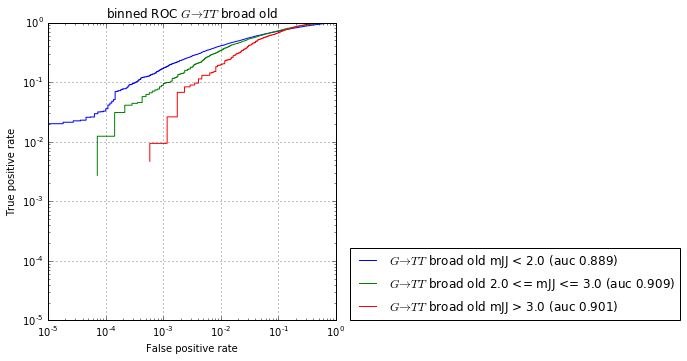

mean = 1723.41, min = 1100.53, max = 1999.96
mean = 2531.45, min = 2000.05, max = 2999.96
mean = 3237.78, min = 3000.00, max = 6841.99


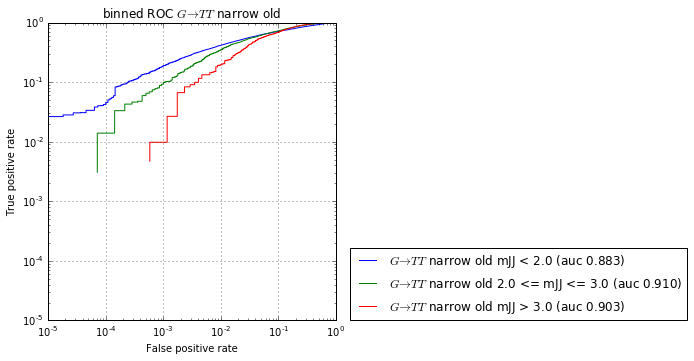

mean = 1637.43, min = 1100.01, max = 2000.00
mean = 2345.69, min = 2000.02, max = 2999.81
mean = 3406.31, min = 3000.72, max = 5303.70


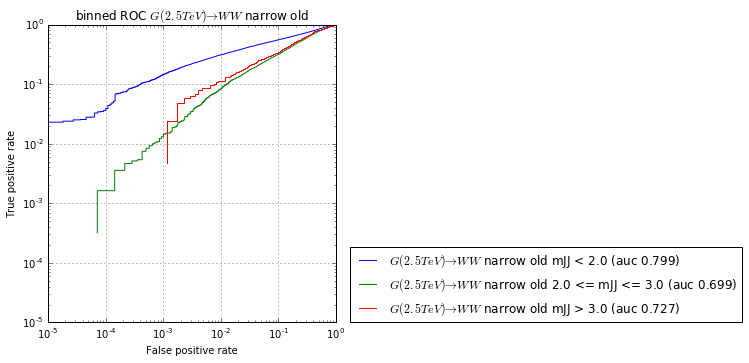

In [15]:
mass_centers = [2500,2500,2500] # Gttbroad: 2500, Gttnarr: 2500
bg = input_data[SM_sample]
aucs = []

for BSM_sample, mass_center in zip(BSM_samples_old,mass_centers): 

    sig = input_data[BSM_sample]
    binned_sig = get_mjj_binned_sample( sig, mass_center, 20 )
    binned_bg = get_mjj_binned_sample( bg, mass_center, 20 )

    [s.describe('mJJ') for s in binned_sig]

    neg_class_losses = [ strategy( b ) for b in binned_bg ]
    pos_class_losses = [ strategy( s ) for s in binned_sig ]
    legend = [ s.name for s in binned_sig ]

    class_labels, losses = amp.get_label_and_score_arrays( neg_class_losses, pos_class_losses )

    auc = amp.plot_roc( class_labels, losses, legend, title='binned ROC ' + sig.title(), legend_loc=(1.05,0) )
    aucs.append( auc )

## new signals

mean = 1155.03, min = 1100.04, max = 1199.99
mean = 1458.92, min = 1200.00, max = 1799.99
mean = 2210.64, min = 1800.02, max = 6007.72


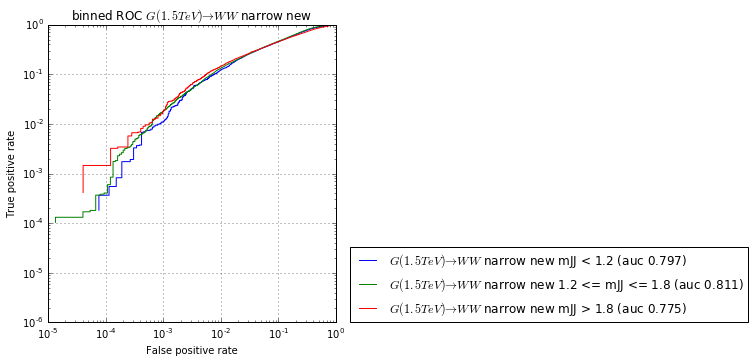

mean = 1716.11, min = 1100.04, max = 1999.97
mean = 2402.47, min = 2000.00, max = 2999.92
mean = 3394.35, min = 3000.08, max = 5897.41


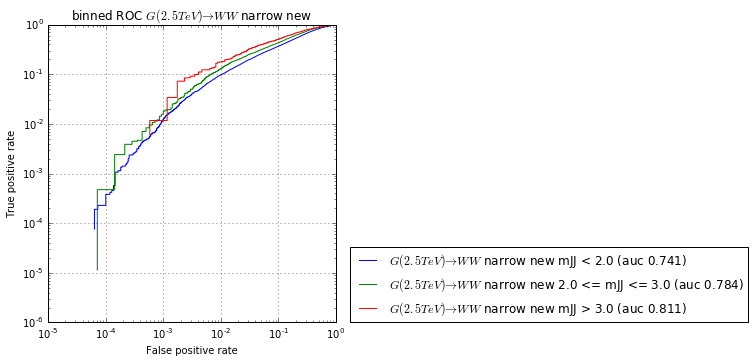

mean = 2031.87, min = 1100.10, max = 2400.00
mean = 2870.81, min = 2400.00, max = 3599.79
mean = 3999.40, min = 3600.08, max = 7073.87


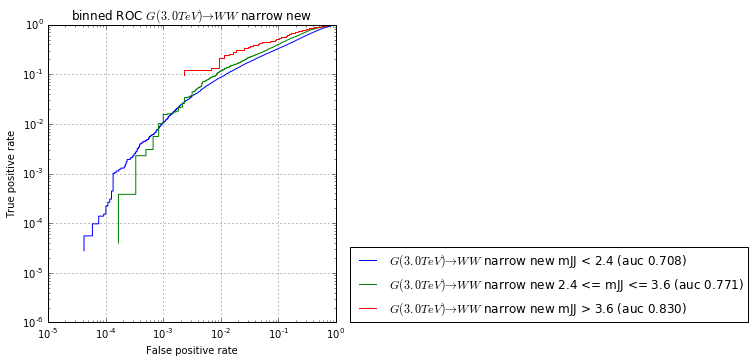

mean = 2999.55, min = 1100.09, max = 3599.96
mean = 4265.89, min = 3600.00, max = 5399.67
mean = 5769.05, min = 5400.43, max = 7609.76


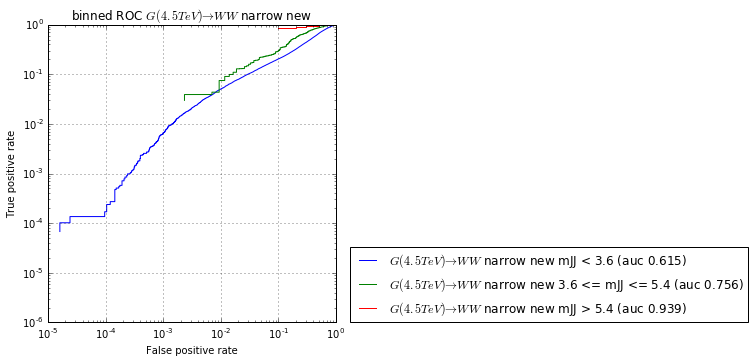

mean = 1152.47, min = 1100.01, max = 1200.00
mean = 1464.46, min = 1200.02, max = 1799.99
mean = 2245.42, min = 1800.01, max = 6969.63


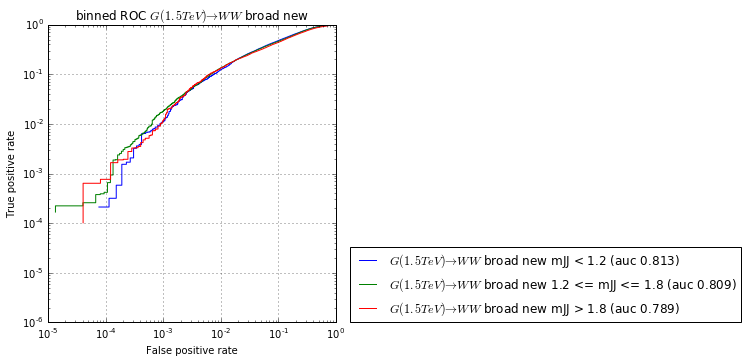

mean = 1670.14, min = 1100.06, max = 1999.99
mean = 2400.49, min = 2000.00, max = 2999.99
mean = 3456.03, min = 3000.08, max = 8607.82


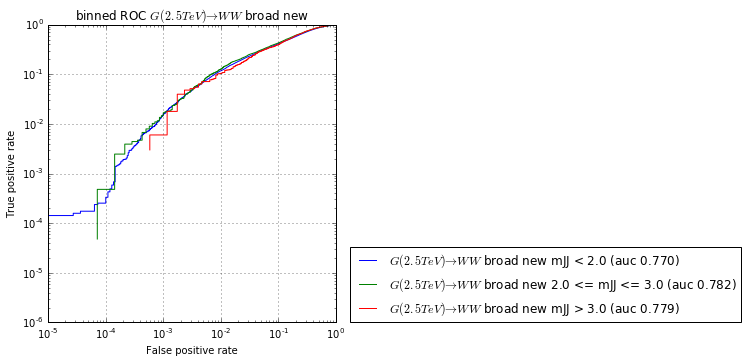

In [17]:
# ['GtoWW15na_new', 'GtoWW25na_new', 'GtoWW30na_new', 'GtoWW45na_new', 'GtoWW15br_new', 'GtoWW25br_new']
mass_centers = [1500,2500,3000,4500,1500,2500]
bg = input_data[SM_sample]
aucs = []

for BSM_sample, mass_center in zip(BSM_samples_new,mass_centers): 

    sig = input_data[BSM_sample]
    binned_sig = get_mjj_binned_sample( sig, mass_center, 20 )
    binned_bg = get_mjj_binned_sample( bg, mass_center, 20 )

    [s.describe('mJJ') for s in binned_sig]

    neg_class_losses = [ strategy( b ) for b in binned_bg ]
    pos_class_losses = [ strategy( s ) for s in binned_sig ]
    legend = [ s.name for s in binned_sig ]

    class_labels, losses = amp.get_label_and_score_arrays( neg_class_losses, pos_class_losses )

    auc = amp.plot_roc( class_labels, losses, legend, title='binned ROC ' + sig.title(), legend_loc=(1.05,0))
    aucs.append( auc )